In [1]:
!pip install tensorflow_datasets

## Ungraded Lab: MNIST Autoencoder

You will now work on an autoencoder that works on the [MNIST dataset](https://www.tensorflow.org/datasets/catalog/mnist). This will encode the inputs to lower resolution images. The decoder should then be able to generate the original input from this compressed representation.

## Imports

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [3]:
def map_image(image, label):
  image = tf.cast(image, dtype=tf.float32)
  image = image / 255.0
  image = tf.reshape(image, shape=(784,))

  return image, image

## Prepare the Dataset

You will load the MNIST data from TFDS into train and test sets. Let's first define a preprocessing function for normalizing and flattening the images. Since we'll be training an autoencoder, this will return `image, image` because the input will also be the target or label while training.


In [4]:
# Load the train and test sets from TFDS

BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024

train_dataset = tfds.load('mnist', as_supervised=True, split="train")
train_dataset = train_dataset.map(map_image)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_dataset = tfds.load('mnist', as_supervised=True, split="test")
test_dataset = test_dataset.map(map_image)
test_dataset = test_dataset.batch(BATCH_SIZE).repeat()

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


## Build the Model

You will now build a simple autoencoder to ingest the data. Like before, the encoder will compress the input and reconstructs it in the decoder output. ![Autoencoder Flowchart](auto.png)

In [8]:
#Bulid the Model

def simple_autoencoder(inputs):
  encoder=tf.keras.layers.Dense(units=32,activation='relu')(inputs)
  decoder=tf.keras.layers.Dense(units=784,activation='sigmoid')(encoder)

  return encoder,decoder
# set the input shape

inputs=tf.keras.Input(shape=(784,))

# get the encoder and decoder output
encoderoutput,decoderoutput=simple_autoencoder(inputs)

# setup the encoder Model because you will visualize its output later
simple_encoder_model=tf.keras.Model(inputs=inputs,outputs=encoderoutput)

# setup the autoencoder Model
simple_autoencoder_model=tf.keras.Model(inputs=inputs,outputs=decoderoutput)

In [9]:
simple_autoencoder_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │          25,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 784)                 │          25,872 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,992 (199.19 KB)

 Trainable params: 50,992 (199.19 KB)

 Non-trainable params: 0 (0.00 B)

## Compile the Model

You will setup the model for training. You can use binary crossentropy to measure the loss between pixel values that range from 0 (black) to 1 (white).

In [10]:
# Compile the model using Adam Optimizer , binary_crossentropy and  metrics=['accuracy']

simple_autoencoder_model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

## Train the Model

In [12]:
# train the model using train_dataset,steps_per_epoch=step,epochs=10
step=256

simple_autoencoder_model.fit(train_dataset,steps_per_epoch=step,epochs=10)

Epoch 1/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.0094 - loss: 0.3696
Epoch 2/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.0099 - loss: 0.1821
Epoch 3/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.0111 - loss: 0.1501
Epoch 4/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.0103 - loss: 0.1326
Epoch 5/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.0103 - loss: 0.1211
Epoch 6/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.0099 - loss: 0.1140
Epoch 7/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.0118 - loss: 0.1082
Epoch 8/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.0107 - loss: 0.1041
Epoch 9/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.0125 - loss: 0.1010
Epoch 10/10
256/256 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.0116 - loss: 0.0990


## Display sample results

You can now visualize the results. The utility functions below will help in plotting the encoded and decoded values.

In [13]:
def display_one_row(disp_images, offset, shape=(28, 28)):
  '''Display sample outputs in one row.'''
  for idx, test_image in enumerate(disp_images):
    plt.subplot(3, 10, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    test_image = np.reshape(test_image, shape)
    plt.imshow(test_image, cmap='gray')


def display_results(disp_input_images, disp_encoded, disp_predicted, enc_shape=(8,4)):
  '''Displays the input, encoded, and decoded output values.'''
  plt.figure(figsize=(15, 5))
  display_one_row(disp_input_images, 0, shape=(28,28,))
  display_one_row(disp_encoded, 10, shape=enc_shape)
  display_one_row(disp_predicted, 20, shape=(28,28,))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


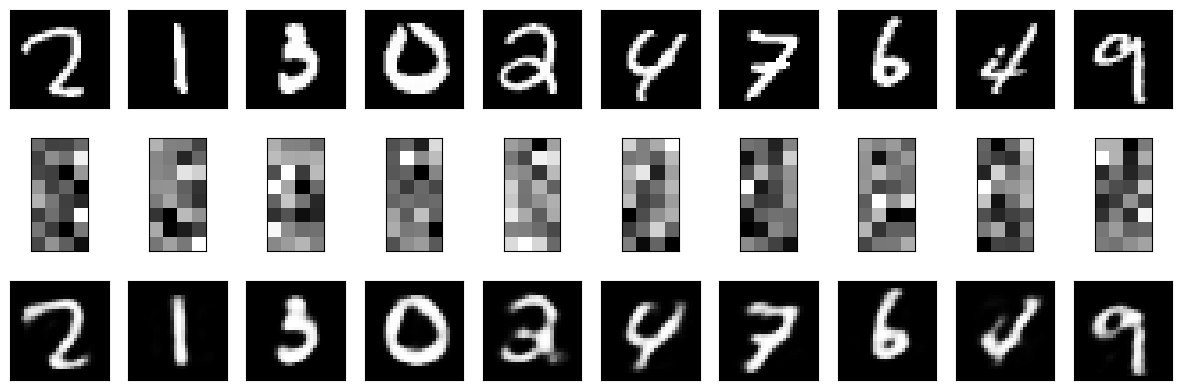

In [14]:
# take 1 batch of the dataset
test_dataset = test_dataset.take(1)

# take the input images and put them in a list
output_samples = []
for input_image, image in tfds.as_numpy(test_dataset):
      output_samples = input_image

# pick 10 random numbers to be used as indices to the list above
idxs = np.random.choice(BATCH_SIZE, size=10)

# get the encoder output
encoded_predicted = simple_encoder_model.predict(test_dataset)

# get a prediction for the test batch
simple_predicted = simple_autoencoder_model.predict(test_dataset)

# display the 10 samples, encodings and decoded values!
display_results(output_samples[idxs], encoded_predicted[idxs], simple_predicted[idxs])